In [1]:
# Steps required
# Create a data pipeline that reads in image from file directory and is able to pass the image to model for training

# Design of U-Net backbone

# Design of loss functions

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

sys.path.append(os.path.join(os.getcwd(), '..', 'input', 'unet-dataset6'))
sys.path.append(os.path.join(os.getcwd(), '..', 'visualisation-helpers'))

from unet import *
from visualisation_helpers import *

# %load_ext autoreload
# %autoreload 2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(tf.version.VERSION)
print(tf.config.list_physical_devices('GPU'))

2.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# 0. Determine class weights

In [4]:
def find_proportion(img):
    count_white = 0
    count_black = 0
    t = 0
    
    for i in img:
        i = np.where(i > 0.5, 1, 0)

    for j in img:
        count_white += np.count_nonzero(j == 1)
        count_black += np.count_nonzero(j == 0)
        t += 1

    proportion_road = (count_white) / (count_white + count_black)
    proportion_foreground = (count_black) / (count_white + count_black)
    print(t)
    return proportion_foreground, proportion_road

In [5]:
# Step 1

train_batch_size = 1 # change back to 8 later
val_batch_size = 10 # change back to 10 later
img_height = 400
img_width = 400
num_channels = 3

In [6]:
# Step 2
# Use a seed of 1 to ensure reproducibility of results
# Use ImageDataGenerator instead

seed = 1
#imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/image')
#labels_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/groundtruth')

imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'images')
labels_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'groundtruth')

# Equivalent to y_train
train_gts_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0,
  subset=None,
  labels=None,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

# Equivalent to y_val
val_gts_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0,
  subset=None,
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=val_batch_size)

Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.


In [7]:
foreground_weight, road_weight = find_proportion(train_gts_ds)

100


# 1. Read in images and preprocess them
Source: https://www.tensorflow.org/tutorials/load_data/images

- Step 1: Specify batch size and image dimensions (Specifying the dimension results in Tensorflow cropping the image for you)
- Step 2: Split the dataset into train and validation split
- Step 3: Normalise the pixel values

In [8]:
# Step 1

train_batch_size = 8 # change back to 8 later
val_batch_size = 10 # change back to 10 later
img_height = 400
img_width = 400
num_channels = 3

In [9]:
# Step 2
# Use a seed of 1 to ensure reproducibility of results
# Use ImageDataGenerator instead

seed = 1
#imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/image')
#labels_dir = os.path.join(os.path.dirname(os.getcwd()), 'datasets/train/groundtruth')

imgs_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'images')
labels_dir = os.path.join(os.path.dirname(os.getcwd()), 'input', 'road-segmentation-ds', 'training', 'groundtruth')

# Equivalent to x_train
train_imgs_ds = tf.keras.utils.image_dataset_from_directory(
  imgs_dir,
  validation_split=0.1,
  subset="training",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

# Equivalent to x_val
val_imgs_ds = tf.keras.utils.image_dataset_from_directory(
  imgs_dir,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=val_batch_size)

# Equivalent to y_train
train_gts_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0.1,
  subset="training",
  labels=None,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=train_batch_size)

# Equivalent to y_val
val_gts_ds = tf.keras.utils.image_dataset_from_directory(
  labels_dir,
  color_mode="grayscale",
  validation_split=0.1,
  subset="validation",
  seed=seed,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=val_batch_size)

Found 100 files belonging to 1 classes.
Using 90 files for training.
Found 100 files belonging to 1 classes.
Using 10 files for validation.
Found 100 files belonging to 1 classes.
Using 90 files for training.
Found 100 files belonging to 1 classes.
Using 10 files for validation.


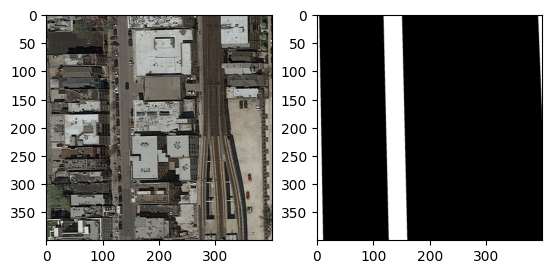

In [10]:
_imgs = []
_gts = []

for images in train_imgs_ds.take(1):
    for i in range(1):
        _imgs.append(images[i].numpy().astype("uint8"))

for gts in train_gts_ds.take(1):
    for i in range(1):
        _gts.append(gts[i].numpy().astype("uint8"))

fig, axs = plt.subplots(1,2)
#fig, axs = plt.subplots(2,2, figsize=(6, 8))

axs[0].imshow(_imgs[0])
axs[1].imshow(_gts[0], cmap="gray")
                   
#axs[1][0].imshow(_imgs[1])
#axs[1][1].imshow(_gts[1], cmap="gray")

In [11]:
# Step 3
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_imgs_ds = train_imgs_ds.map(lambda x: (normalization_layer(x)))
val_imgs_ds = val_imgs_ds.map(lambda x: (normalization_layer(x)))

train_gts_ds = train_gts_ds.map(lambda x: (normalization_layer(x)))
val_gts_ds = val_gts_ds.map(lambda x: (normalization_layer(x)))

In [12]:
sample_img_batch = next(iter(train_imgs_ds))
sample_image = sample_img_batch[0]

sample_gt_batch = next(iter(train_gts_ds))
sample_gt = sample_gt_batch[0]

print(f'Sample image, min. pixel value: {np.min(sample_image)}, max. pixel value: {np.max(sample_image)}')
print(f'Sample gt, min. pixel value: {np.min(sample_gt)}, max. pixel value: {np.max(sample_gt)}')

Sample image, min. pixel value: 0.0, max. pixel value: 1.0
Sample gt, min. pixel value: 0.0, max. pixel value: 0.9294118285179138


# 2. Instantiate model and train model¶

In [13]:
# Show summary of the model
input_shape = (None, img_height, img_width, num_channels)
unet_model = UNet(input_shape, foreground_weight, road_weight)
unet_model.build(input_shape) # input shape: (None, 400, 400, 3)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 encoder__conv_block (Encod  (None, 400, 400, 64)         38720     ['input_1[0][0]']             
 er_ConvBlock)                                                                                    
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 200, 200, 64)         0         ['encoder__conv_block[0][0]'] 
 D)                                                                                               
                                                                                              

In [14]:
RE_TRAIN = True

In [15]:
if RE_TRAIN:
    num_epochs = 200 # 100
    generate_every = 25 # 10
    lr = 0.0001

    # Arrays to store results
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_ious = []
    val_ious = []
    train_dices = []
    val_dices = []

    # Convert datasets into an list for easy iteration
    train_imgs = list(iter(train_imgs_ds))
    train_gts = list(iter(train_gts_ds))
    val_imgs = list(iter(val_imgs_ds))
    val_gts = list(iter(val_gts_ds))

    # Instantiate model
    input_shape = (None, img_height, img_width, num_channels)
    unet_model = UNet(input_shape, foreground_weight, road_weight)

    # Define optimiser
    optimiser = tf.keras.optimizers.Adam(learning_rate = lr)
    unet_model.compile(optimizer = optimiser, loss = unet_model.compute_loss)

    # Start training loop
    for epoch in range(num_epochs):

        print(f'Start of epoch {epoch}.')
        for batch_no, train_imgs_batch in enumerate(train_imgs):

            with tf.GradientTape() as tape:

                # Pass images into model and get prediction
                train_outputs = unet_model(train_imgs[batch_no])

                # Calculate loss
                train_loss = unet_model.compute_loss(train_gts[batch_no], train_outputs)

            # Compute and apply gradients
            grads = tape.gradient(train_loss, unet_model.trainable_weights)
            clipped_grads = [tf.clip_by_value(grad, -5.0, 5.0) if grad is not None else None for grad in grads]
            optimiser.apply_gradients(zip(clipped_grads, unet_model.trainable_weights))

        # Calculate on validation set
        val_outputs = unet_model(val_imgs[0]) # only one batch for validation
        val_loss = unet_model.compute_loss(val_gts[0], val_outputs)

        # Compute metrics
        train_acc, train_iou, train_dice = unet_model.compute_metrics(train_gts[batch_no], train_outputs)
        val_acc, val_iou, val_dice = unet_model.compute_metrics(val_gts[0], val_outputs)

        # Save results
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_ious.append(train_iou)
        train_dices.append(train_dice)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_ious.append(val_iou)
        val_dices.append(val_dice)

        print(f'tr_Loss: {train_loss}, tr_acc: {train_acc}, tr_iou: {train_iou}, tr_dice: {train_dice}')
        print(f'val_Loss: {val_loss}, val_acc: {val_acc}, val_iou: {val_iou}, val_dice: {val_dice}')

        # Generate the segmentation map and save it every 'generate_every' epochs
        if epoch % generate_every == 0 and epoch > 0:
            np.save(f'train_epoch_{epoch}', train_outputs[0])
            
    unet_model.save_weights('unet_weights.h5')
else:
    unet_model.load_weights('unet_weights.h5')
        

Start of epoch 0.
tr_Loss: 0.2773863971233368, tr_acc: 0.7286437749862671, tr_iou: 0.14133542776107788, tr_dice: 0.24764308333396912
val_Loss: 0.2540220618247986, val_acc: 0.7927706241607666, val_iou: 0.11264614015817642, val_dice: 0.20188310742378235
Start of epoch 1.
tr_Loss: 0.27864646911621094, tr_acc: 0.7286437749862671, tr_iou: 0.12902316451072693, tr_dice: 0.22853320837020874
val_Loss: 0.24578988552093506, val_acc: 0.7927706241607666, val_iou: 0.10877875238656998, val_dice: 0.1955026388168335
Start of epoch 2.
tr_Loss: 0.26166218519210815, tr_acc: 0.7286437749862671, tr_iou: 0.1523139774799347, tr_dice: 0.26426470279693604
val_Loss: 0.2393515408039093, val_acc: 0.7927706241607666, val_iou: 0.12384700775146484, val_dice: 0.21899977326393127
Start of epoch 3.
tr_Loss: 0.2522050440311432, tr_acc: 0.7286437749862671, tr_iou: 0.17567357420921326, tr_dice: 0.29875731468200684
val_Loss: 0.2384730577468872, val_acc: 0.7927706241607666, val_iou: 0.13353955745697021, val_dice: 0.233712524

<Figure size 2000x1000 with 0 Axes>

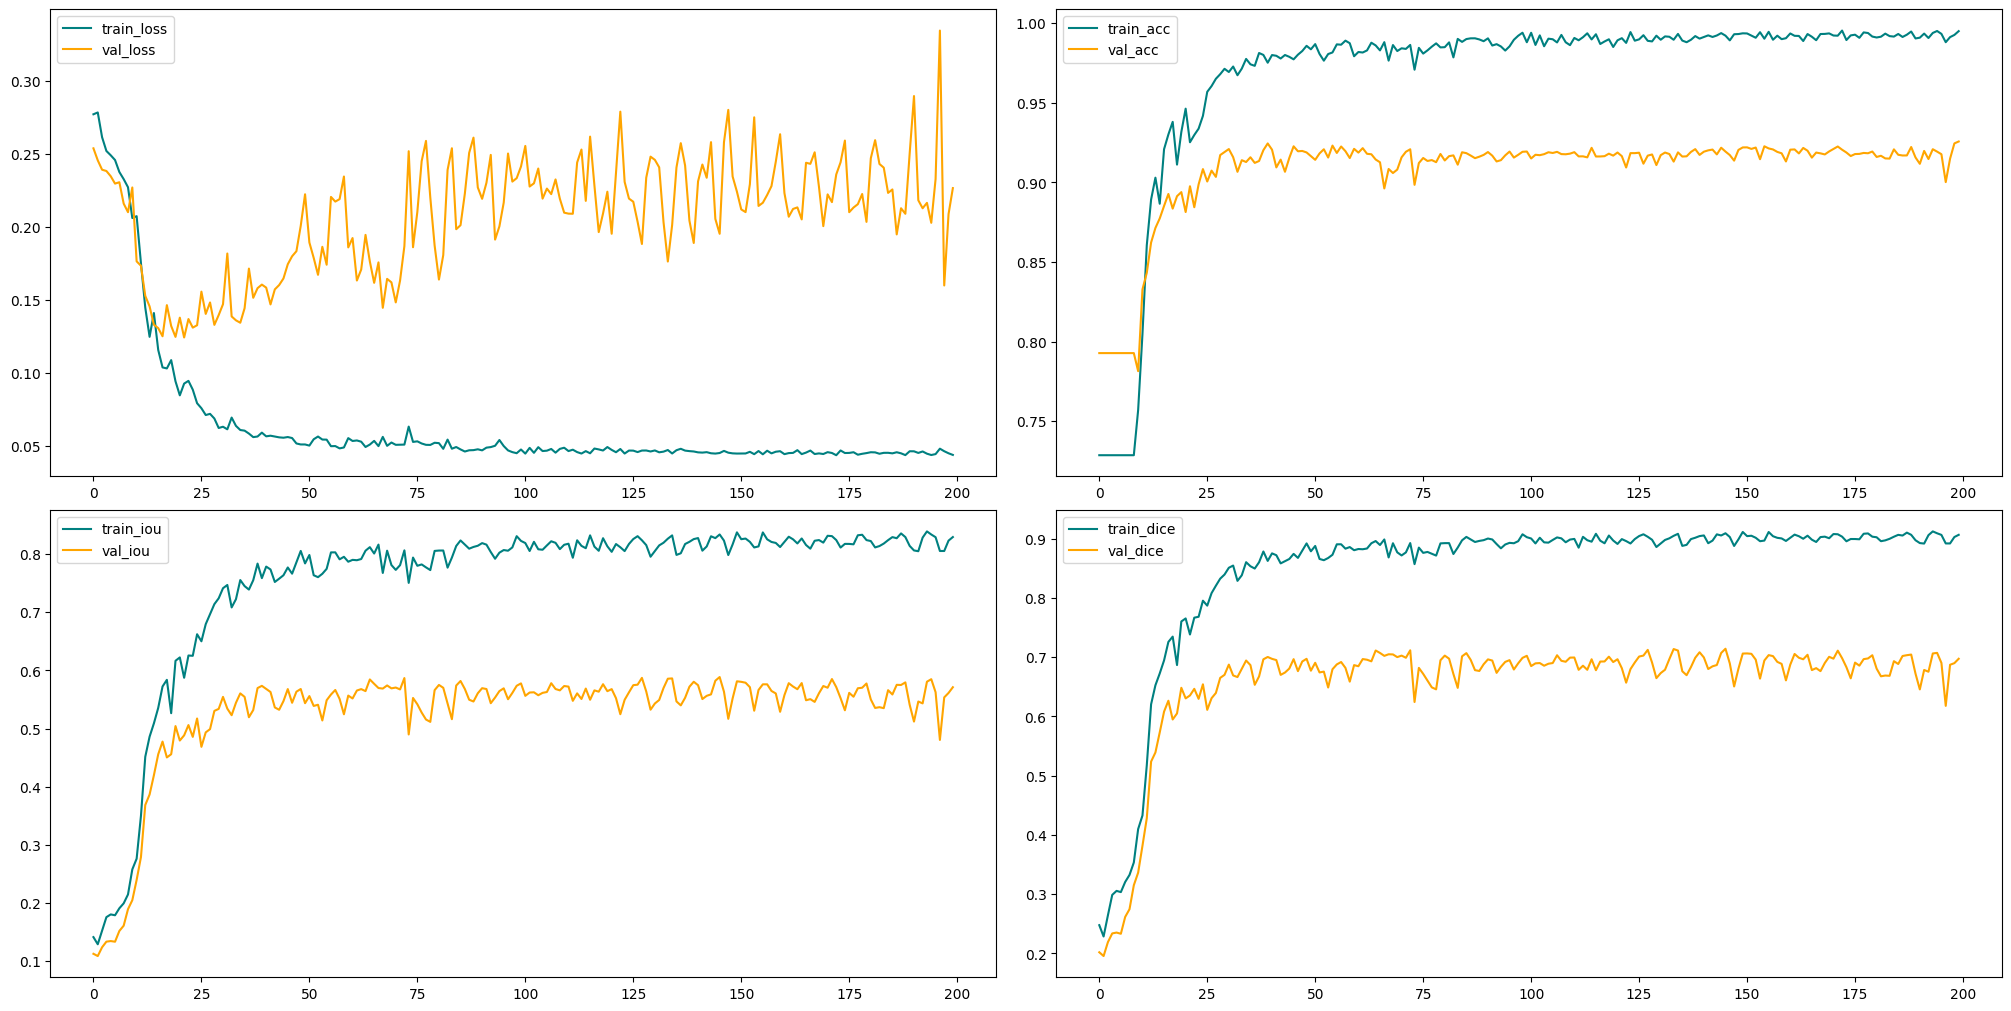

In [16]:
plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(2, 2, constrained_layout = True)
epochs = [_ for _ in range(len(train_losses))]

axs[0][0].plot(epochs, train_losses, color='teal', label='train_loss')
axs[0][0].plot(epochs, val_losses, color='orange', label='val_loss')
axs[0][0].legend(loc='upper left')

axs[0][1].plot(epochs, train_accs, color='teal', label='train_acc')
axs[0][1].plot(epochs, val_accs, color='orange', label='val_acc')
axs[0][1].legend(loc='upper left')

axs[1][0].plot(epochs, train_ious, color='teal', label='train_iou')
axs[1][0].plot(epochs, val_ious, color='orange', label='val_iou')
axs[1][0].legend(loc='upper left')

axs[1][1].plot(epochs, train_dices, color='teal', label='train_dice')
axs[1][1].plot(epochs, val_dices, color='orange', label='val_dice')
axs[1][1].legend(loc='upper left')

In [17]:
def output_to_segmap(output_nparray, threshold = 0.5):
    
    """Converts model's output, a numpy array, into a segmentation map 
    
    Args:
        output_nparray: numpy array, model's output
        threshold: float, scalar to threshold predicted probability
    Returns:
        output_segmap: numpy array, segmentation map of model's output
    """
    
    output_segmap = np.where(output_nparray > 0.5, 1., 0.)
    output_segmap = output_segmap*255.
    return output_segmap

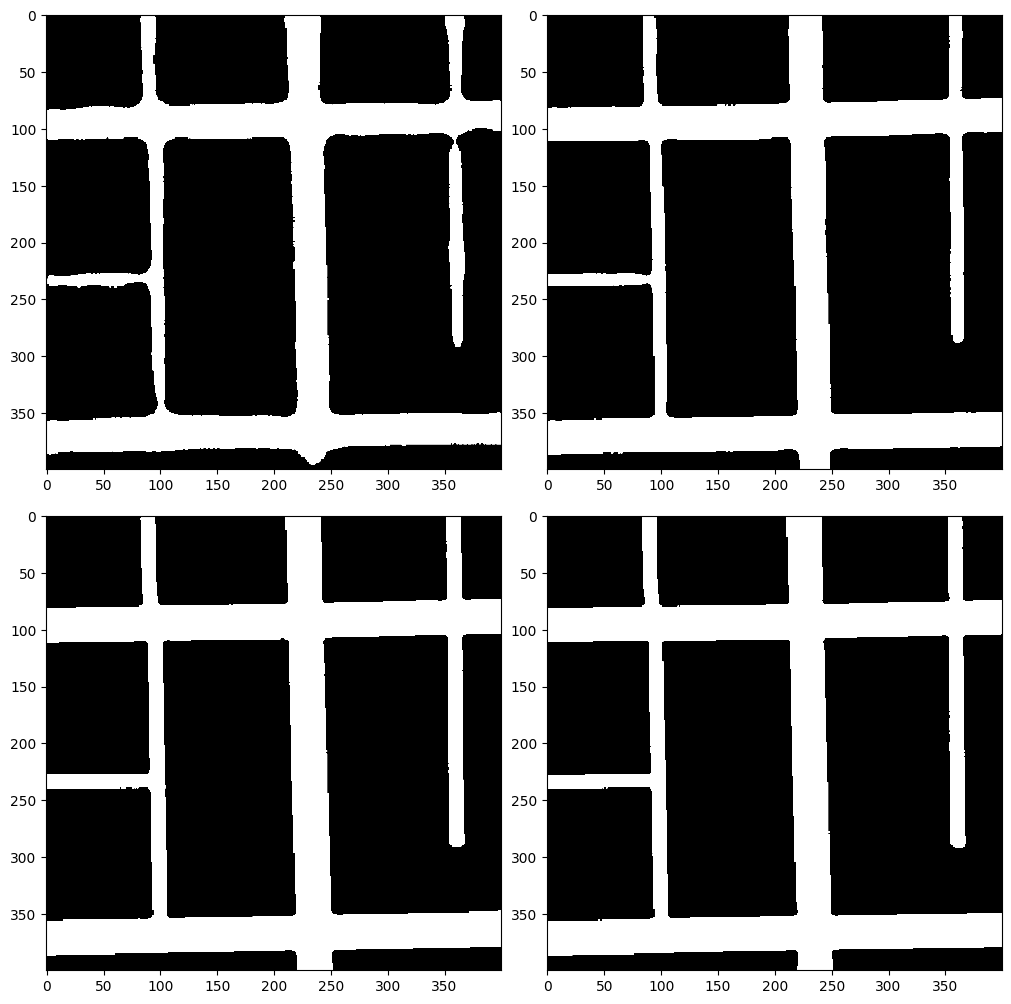

In [18]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(2, 2, constrained_layout = True)

axs[0][0].imshow(output_to_segmap(np.load('train_epoch_25.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[0][1].imshow(output_to_segmap(np.load('train_epoch_75.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[1][0].imshow(output_to_segmap(np.load('train_epoch_125.npy')), cmap='gray', vmin = 0, vmax = 1)
axs[1][1].imshow(output_to_segmap(np.load('train_epoch_175.npy')), cmap='gray', vmin = 0, vmax = 1)

 # 2.3. Comparison of predicted segmentation map with groundtruth segmentation map

In [19]:
# Get data
val_gts = list(iter(val_gts_ds))
val_imgs = list(iter(val_imgs_ds))

# Get predictions
val_outputs = unet_model(val_imgs[0])

# Threshold probabilities to get class labels
val_outputs = np.array(val_outputs)
val_outputs = np.where(val_outputs > 0.5, 1., 0.)

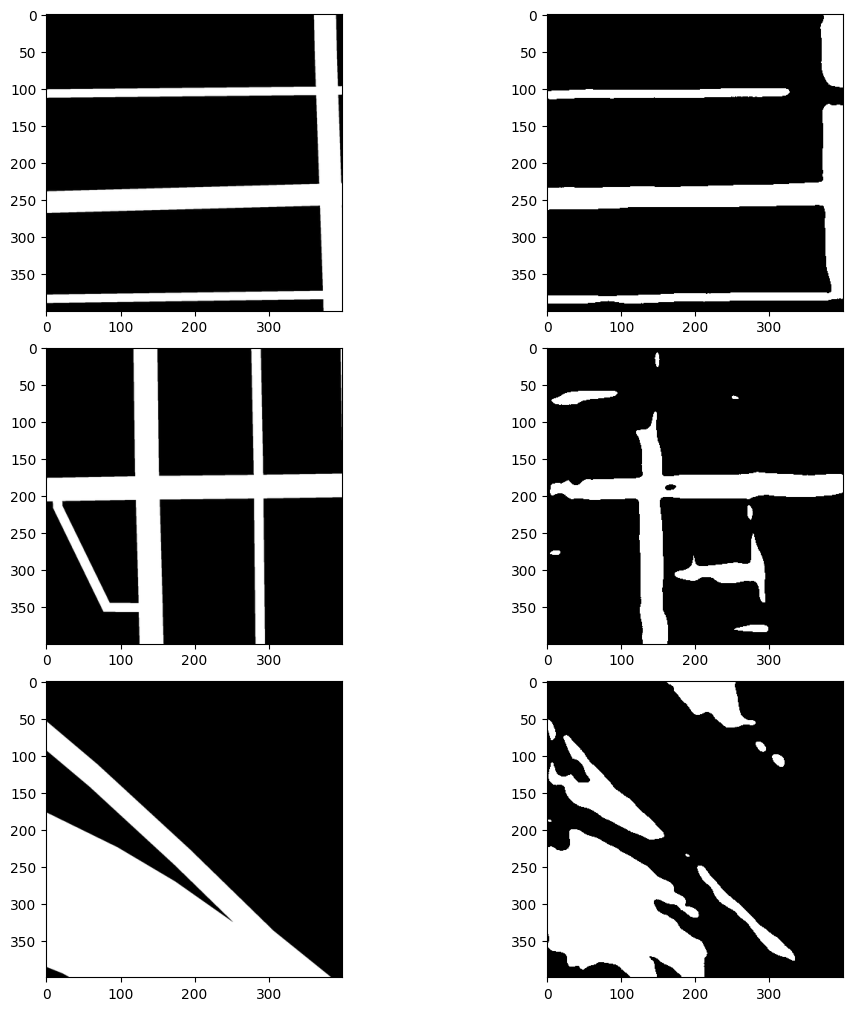

In [20]:
val_gts = val_gts[:3]

fig, axs = plt.subplots(3, 2, constrained_layout = True)
axs[0][0].imshow(val_gts[0][0], cmap = 'gray')
axs[0][1].imshow(val_outputs[0], cmap = 'gray')

axs[1][0].imshow(val_gts[0][1], cmap = 'gray')
axs[1][1].imshow(val_outputs[1], cmap = 'gray')

axs[2][0].imshow(val_gts[0][2], cmap = 'gray')
axs[2][1].imshow(val_outputs[2], cmap = 'gray')